In [54]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

In [2]:
train_labels_path = "train_labels.csv"
test_labels_path = "test_labels.csv"
train_dir = "DATASET/train"
test_dir = "DATASET/test"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_labels = pd.read_csv(train_labels_path)
test_labels = pd.read_csv(test_labels_path)

In [5]:
train_labels, val_labels = train_test_split(
    train_labels, test_size=0.2, stratify=train_labels['label'], random_state=42
)

In [6]:
emotion_classes = {0: "Surprise", 1: "Fear", 2: "Disgust", 3: "Happy", 4: "Sad", 5: "Angry", 6: "Neutral"}

In [7]:
print("Dataset Analysis:")
print(f"Number of training samples: {len(train_labels)}")
print(f"Number of testing samples: {len(test_labels)}")
print("Class distribution in training set:")
print(train_labels['label'].value_counts().rename(emotion_classes))
print("Class distribution in validation set:")
print(val_labels['label'].value_counts().rename(emotion_classes))
print("\nClass distribution in testing set:")
print(test_labels['label'].value_counts().rename(emotion_classes))

Dataset Analysis:
Number of training samples: 9816
Number of testing samples: 3068
Class distribution in training set:
label
Happy       3817
Neutral     2019
Sad         1585
Surprise    1032
Disgust      574
Angry        564
Fear         225
Name: count, dtype: int64
Class distribution in validation set:
label
Happy       955
Neutral     505
Sad         397
Surprise    258
Disgust     143
Angry       141
Fear         56
Name: count, dtype: int64

Class distribution in testing set:
label
Happy       1185
Neutral      680
Sad          478
Surprise     329
Angry        162
Disgust      160
Fear          74
Name: count, dtype: int64


In [8]:
def visualize_samples(labels_df, dataset_path, num_rows=3):
    classes = sorted(labels_df['label'].unique())
    fig, axes = plt.subplots(num_rows, len(classes), figsize=(15, 5 * num_rows))

    for row in range(num_rows):
        for col, class_label in enumerate(classes):
            sample = labels_df[labels_df['label'] == class_label].sample(1).iloc[0]
            img_path = os.path.join(dataset_path, str(sample['label']), sample['image'])
            image = Image.open(img_path)

            ax = axes[row, col]
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(emotion_classes[class_label])

    plt.tight_layout()
    plt.show()

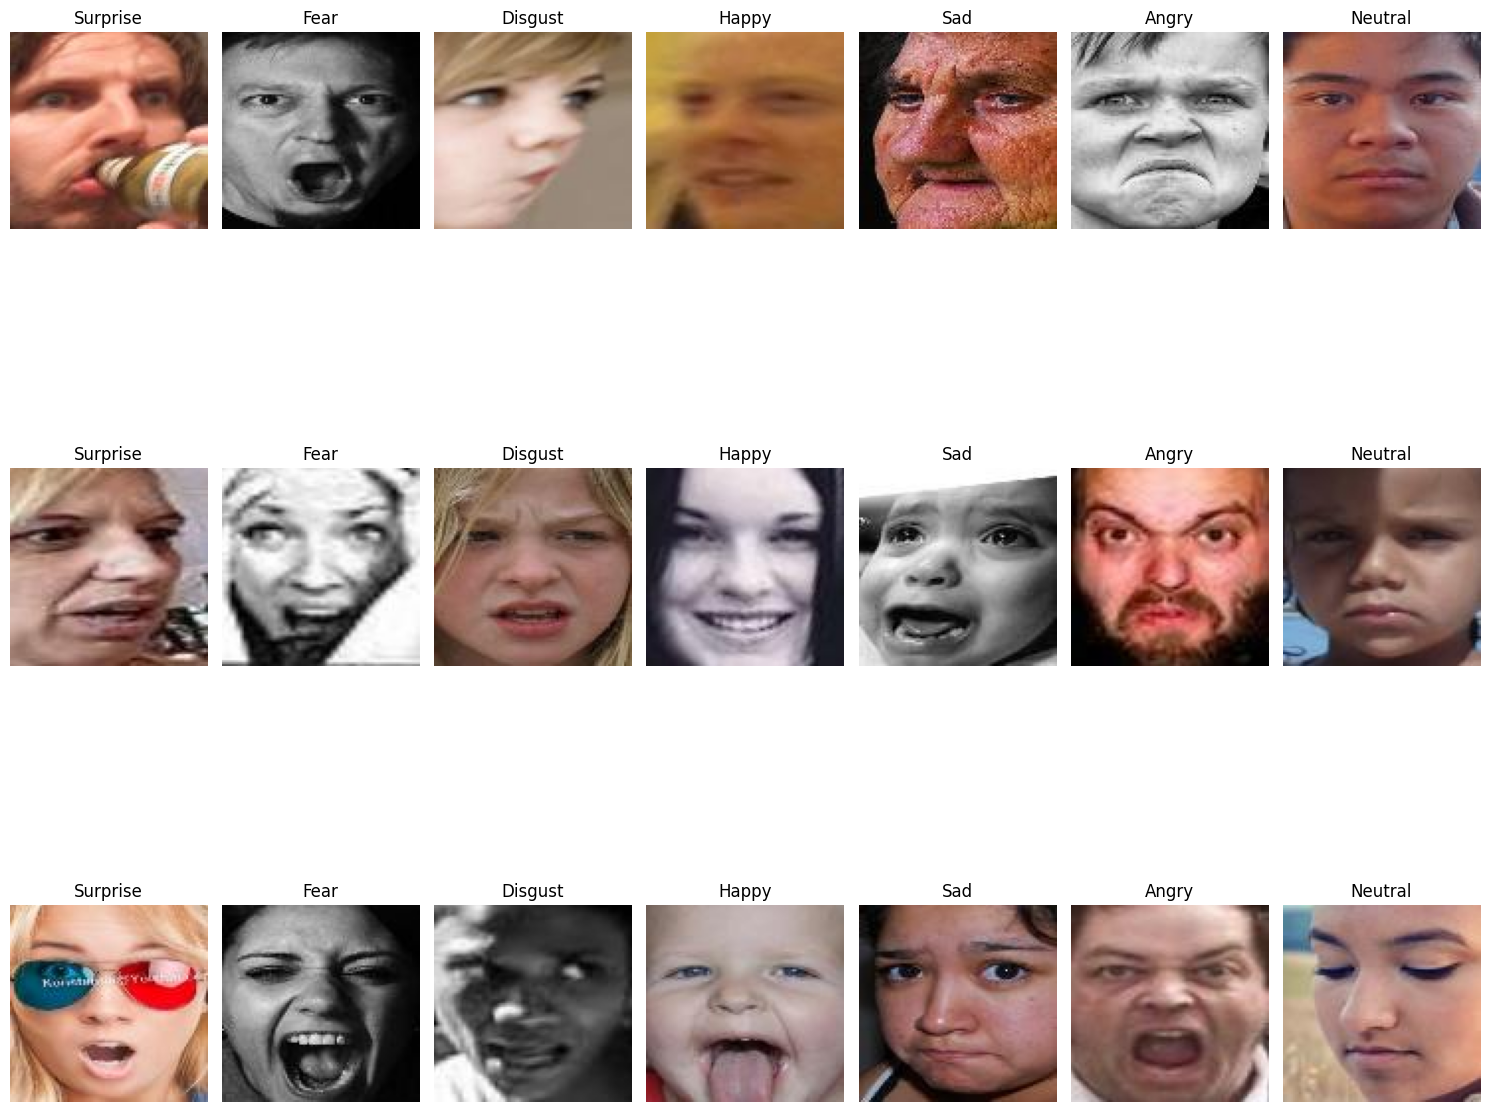

In [9]:
visualize_samples(train_labels, train_dir, num_rows=3)

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
class EmotionDataset(Dataset):
    def __init__(self, labels_df, root_dir, transform=None):
        self.labels_df = labels_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = os.path.join(self.root_dir, str(row['label']), row['image'])
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"File not found: {img_path}")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = row['label']
        return image, label

In [13]:
train_dataset = EmotionDataset(train_labels, train_dir, train_transform)
val_dataset = EmotionDataset(val_labels, train_dir, test_transform)
test_dataset = EmotionDataset(test_labels, test_dir, test_transform)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
baseline_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, 7)
baseline_model = baseline_model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [17]:
def train_model(model, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Val Accuracy: {val_acc:.4f}")

In [18]:
print("Training Baseline Model...")
train_model(baseline_model, train_loader, val_loader, num_epochs=20)

Training Baseline Model...
Epoch 1/20, Loss: 1.2264, Val Accuracy: 0.6864
Epoch 2/20, Loss: 0.9079, Val Accuracy: 0.6978
Epoch 3/20, Loss: 0.8214, Val Accuracy: 0.6310
Epoch 4/20, Loss: 0.7656, Val Accuracy: 0.7206
Epoch 5/20, Loss: 0.7383, Val Accuracy: 0.7690
Epoch 6/20, Loss: 0.5846, Val Accuracy: 0.8187
Epoch 7/20, Loss: 0.5250, Val Accuracy: 0.8228
Epoch 8/20, Loss: 0.4966, Val Accuracy: 0.8334
Epoch 9/20, Loss: 0.4745, Val Accuracy: 0.8342
Epoch 10/20, Loss: 0.4601, Val Accuracy: 0.8350
Epoch 11/20, Loss: 0.4249, Val Accuracy: 0.8314
Epoch 12/20, Loss: 0.4234, Val Accuracy: 0.8346
Epoch 13/20, Loss: 0.4178, Val Accuracy: 0.8371
Epoch 14/20, Loss: 0.4163, Val Accuracy: 0.8350
Epoch 15/20, Loss: 0.4201, Val Accuracy: 0.8403
Epoch 16/20, Loss: 0.4137, Val Accuracy: 0.8415
Epoch 17/20, Loss: 0.4118, Val Accuracy: 0.8399
Epoch 18/20, Loss: 0.4090, Val Accuracy: 0.8391
Epoch 19/20, Loss: 0.4085, Val Accuracy: 0.8354
Epoch 20/20, Loss: 0.4114, Val Accuracy: 0.8399


In [74]:
enhanced_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

enhanced_model.fc = nn.Sequential(
    nn.Linear(enhanced_model.fc.in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 7)
)
for param in enhanced_model.layer4.parameters():
    param.requires_grad = True

enhanced_model = enhanced_model.to(device)

In [75]:
enhanced_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [76]:
optimizer = optim.Adam(enhanced_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [77]:
print("Training Enhanced Model...")
train_model(enhanced_model, train_loader, val_loader, num_epochs=25)

Training Enhanced Model...
Epoch 1/25, Loss: 1.3318, Val Accuracy: 0.6179
Epoch 2/25, Loss: 1.0311, Val Accuracy: 0.6741
Epoch 3/25, Loss: 0.9284, Val Accuracy: 0.7193
Epoch 4/25, Loss: 0.8720, Val Accuracy: 0.7308
Epoch 5/25, Loss: 0.8223, Val Accuracy: 0.7255
Epoch 6/25, Loss: 0.7123, Val Accuracy: 0.8020
Epoch 7/25, Loss: 0.6481, Val Accuracy: 0.8045
Epoch 8/25, Loss: 0.6181, Val Accuracy: 0.8057
Epoch 9/25, Loss: 0.5981, Val Accuracy: 0.8122
Epoch 10/25, Loss: 0.5723, Val Accuracy: 0.8045
Epoch 11/25, Loss: 0.5632, Val Accuracy: 0.8143
Epoch 12/25, Loss: 0.5490, Val Accuracy: 0.8110
Epoch 13/25, Loss: 0.5494, Val Accuracy: 0.8122
Epoch 14/25, Loss: 0.5415, Val Accuracy: 0.8130
Epoch 15/25, Loss: 0.5463, Val Accuracy: 0.8147
Epoch 16/25, Loss: 0.5339, Val Accuracy: 0.8163
Epoch 17/25, Loss: 0.5296, Val Accuracy: 0.8102
Epoch 18/25, Loss: 0.5333, Val Accuracy: 0.8175
Epoch 19/25, Loss: 0.5309, Val Accuracy: 0.8147
Epoch 20/25, Loss: 0.5350, Val Accuracy: 0.8175
Epoch 21/25, Loss: 0.5

In [78]:
 def test_model(model, test_loader):
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(test_labels, test_preds)
    f1 = f1_score(test_labels, test_preds, average='weighted')
    precision = precision_score(test_labels, test_preds, average='weighted')
    recall = recall_score(test_labels, test_preds, average='weighted')
    report = classification_report(test_labels, test_preds, target_names=emotion_classes.values())
    print(f"Test Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(report)

    cm = confusion_matrix(test_labels, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_classes.values())
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


Evaluating Baseline Model...
Test Accuracy: 0.8458, F1-Score: 0.8438, Precision: 0.8427, Recall: 0.8458
              precision    recall  f1-score   support

    Surprise       0.84      0.83      0.84       329
        Fear       0.64      0.57      0.60        74
     Disgust       0.59      0.47      0.53       160
       Happy       0.93      0.93      0.93      1185
         Sad       0.81      0.85      0.83       478
       Angry       0.74      0.72      0.73       162
     Neutral       0.82      0.85      0.83       680

    accuracy                           0.85      3068
   macro avg       0.77      0.75      0.76      3068
weighted avg       0.84      0.85      0.84      3068



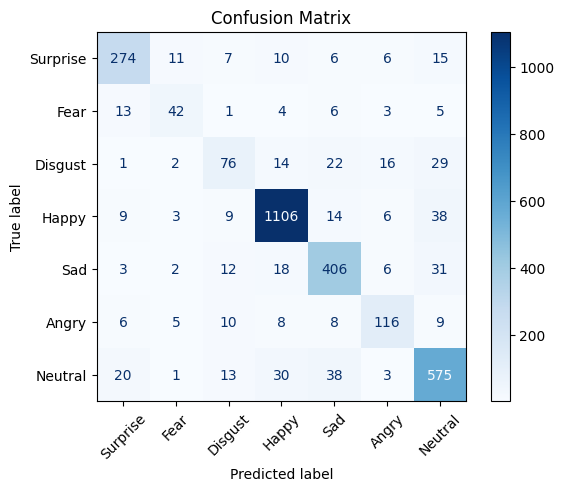

In [79]:
print("\nEvaluating Baseline Model...")
test_model(baseline_model, test_loader)


Evaluating Enhanced Model...
Test Accuracy: 0.8214, F1-Score: 0.8165, Precision: 0.8160, Recall: 0.8214
              precision    recall  f1-score   support

    Surprise       0.80      0.87      0.83       329
        Fear       0.73      0.43      0.54        74
     Disgust       0.41      0.27      0.32       160
       Happy       0.94      0.92      0.93      1185
         Sad       0.79      0.82      0.80       478
       Angry       0.64      0.72      0.68       162
     Neutral       0.78      0.82      0.80       680

    accuracy                           0.82      3068
   macro avg       0.73      0.69      0.70      3068
weighted avg       0.82      0.82      0.82      3068



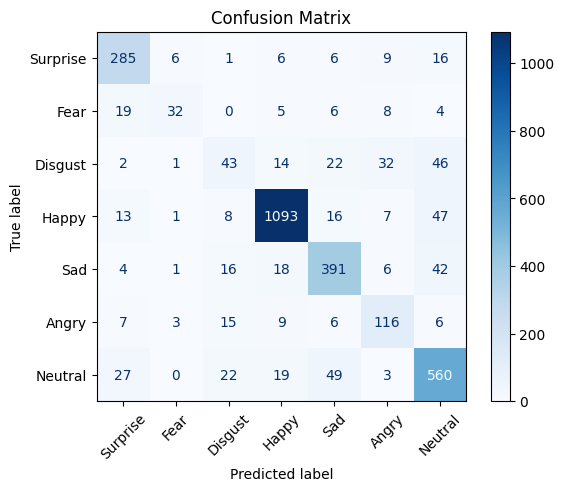

In [80]:
print("\nEvaluating Enhanced Model...")
test_model(enhanced_model, test_loader)

In [102]:
new_image_labels_path = "new_image_labels.csv"
new_data_dir = "newData"

In [103]:
new_image_labels = pd.read_csv(new_image_labels_path)

In [104]:
new_train_dataset = EmotionDataset(new_image_labels, new_data_dir, train_transform)
combined_dataset = ConcatDataset([train_dataset, new_train_dataset])

In [105]:
new_train_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

In [106]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device)

In [107]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [108]:
print("Training the Model Using Additional Data...")
train_model(model, new_train_loader, val_loader, num_epochs=20)

Training the Model Using Additional Data...
Epoch 1/20, Loss: 1.1654, Val Accuracy: 0.6130
Epoch 2/20, Loss: 0.9049, Val Accuracy: 0.6827
Epoch 3/20, Loss: 0.8277, Val Accuracy: 0.7418
Epoch 4/20, Loss: 0.7483, Val Accuracy: 0.7475
Epoch 5/20, Loss: 0.7131, Val Accuracy: 0.7743
Epoch 6/20, Loss: 0.5577, Val Accuracy: 0.8171
Epoch 7/20, Loss: 0.5030, Val Accuracy: 0.8228
Epoch 8/20, Loss: 0.4864, Val Accuracy: 0.8281
Epoch 9/20, Loss: 0.4709, Val Accuracy: 0.8314
Epoch 10/20, Loss: 0.4394, Val Accuracy: 0.8305
Epoch 11/20, Loss: 0.4079, Val Accuracy: 0.8326
Epoch 12/20, Loss: 0.4000, Val Accuracy: 0.8346
Epoch 13/20, Loss: 0.4074, Val Accuracy: 0.8318
Epoch 14/20, Loss: 0.3953, Val Accuracy: 0.8338
Epoch 15/20, Loss: 0.3851, Val Accuracy: 0.8338
Epoch 16/20, Loss: 0.3841, Val Accuracy: 0.8318
Epoch 17/20, Loss: 0.3890, Val Accuracy: 0.8350
Epoch 18/20, Loss: 0.3929, Val Accuracy: 0.8367
Epoch 19/20, Loss: 0.3985, Val Accuracy: 0.8375
Epoch 20/20, Loss: 0.3885, Val Accuracy: 0.8334



Evaluating Additional Model...
Test Accuracy: 0.8422, F1-Score: 0.8404, Precision: 0.8401, Recall: 0.8422
              precision    recall  f1-score   support

    Surprise       0.82      0.85      0.84       329
        Fear       0.63      0.64      0.63        74
     Disgust       0.57      0.46      0.51       160
       Happy       0.93      0.92      0.93      1185
         Sad       0.81      0.86      0.83       478
       Angry       0.80      0.70      0.75       162
     Neutral       0.81      0.83      0.82       680

    accuracy                           0.84      3068
   macro avg       0.77      0.75      0.76      3068
weighted avg       0.84      0.84      0.84      3068



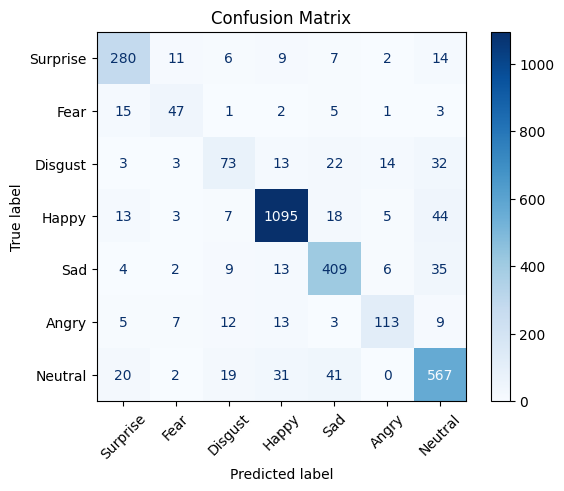

In [110]:
print("\nEvaluating Additional Model...")
test_model(model, test_loader)

In [111]:
model_path = "emotion_detection.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to emotion_detection.pth
